<a href="https://colab.research.google.com/github/NsiriRoua/tensor_flow/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello !**

In this notebook, I will try to build a siamese network using TensorFlow , and mnsit fashion dataset

# **Imports**

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  

In [24]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Flatten,Dense,Input,Dropout,Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt


import numpy as np 
from PIL import Image,ImageFont,ImageDraw
import random

# **Let's prepare the dataset**

In [4]:
#Let's create a function that generate tge pairs
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [6]:
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
train_images.dtype

dtype('uint8')

In [8]:
train_images=train_images.astype('float32')
test_images=test_images.astype('float32')

In [9]:
#Normalize values
train_images=train_images/255.0
test_images=test_images/255.0

In [10]:
#Let's create pairs on train and test sets
tr_pairs,tr_y=create_pairs_on_set(train_images,train_labels)
ts_pairs,ts_y=create_pairs_on_set(test_images,test_labels)




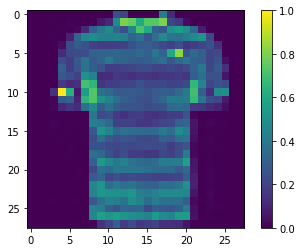

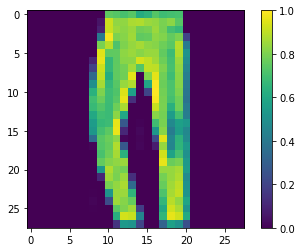

0.0


In [14]:
# array index
this_pair = 5

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

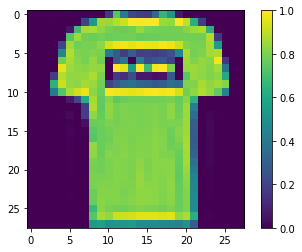

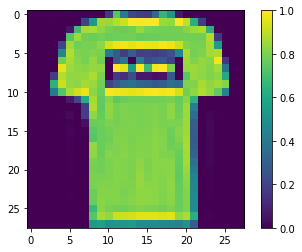

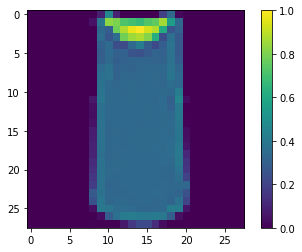

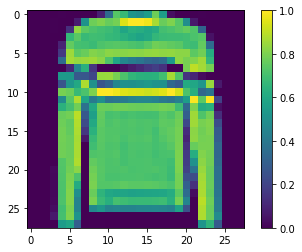

In [15]:
# print other pairs

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])


# **Now,let's build the model**

In [22]:
def initialize_base_network():
  input=Input(shape=(28,28,),name='base_input')
  x=Flatten(name="Flatten_Input")(input)
  x=Dense(128,activation='relu',name='first_base_dense')(x)
  x=Dropout(0.1,name='first_dropout')(x)
  x=Dense(128,activation='relu',name='second_base_dense')(x)
  x=Dropout(0.1,name='second_dropout')(x)
  x=Dense(128,activation='relu',name='third_base_dense')(x)

  return Model(inputs=input,outputs=x)

In [20]:
def euclidean_distance(vects):
  x,y=vects
  sum_square=K.sum(K.square(x-y),axis=1,keepdims=True)
  return K.sqrt(K.maximum(sum_square,K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

Let's see our network

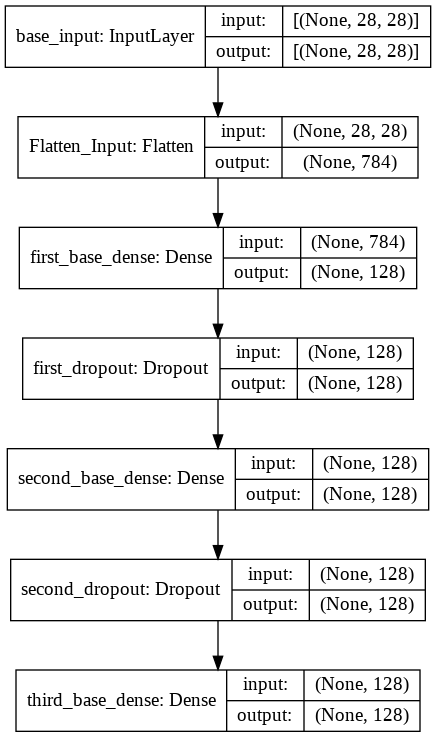

In [23]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

Let's now build the Siamese Network

In [25]:
#Let's start wwith the left input
input_a=Input(shape=(28,28,),name='left_input')
vect_output_a=base_network(input_a)

#Let's create the right input
input_b=Input(shape=(28,28,),name='right_input')
vect_output_b=base_network(input_b)

In [28]:
#Let's measure the similarity of the two vectors ouputs
output=Lambda(euclidean_distance,name='output_layer',output_shape=eucl_dist_output_shape)([vect_output_a,vect_output_b])

In [32]:
#Let's see our model
model=Model([input_a,input_b],output)

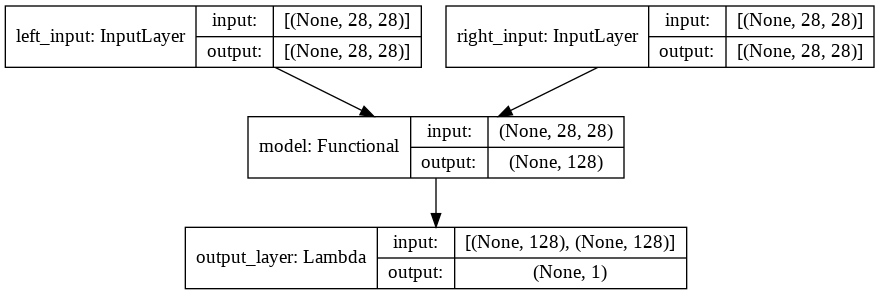

In [33]:
#Plot the graph
plot_model(model,show_shapes=True,show_layer_names=True,to_file='outer-model.png')

# **Let's train our model**

In [34]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))


Epoch 1/20
938/938 [==============================] - 9s 9ms/step - loss: 0.1555 - val_loss: 0.0890
Epoch 2/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0828 - val_loss: 0.0745
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0719 - val_loss: 0.0706
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0681 - val_loss: 0.0666
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0636 - val_loss: 0.0643
Epoch 6/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0617 - val_loss: 0.0638
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0606 - val_loss: 0.0668
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0591 - val_loss: 0.0634
Epoch 9/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0565 - val_loss: 0.0642
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0557 - val_loss: 0.0647

# **Evaluate the model**

In [35]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [36]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 1ms/step - loss: 0.0676
Loss = 0.0676039531826973, Train Accuracy = 0.9315719286547758 Test Accuracy = 0.9095595595595596


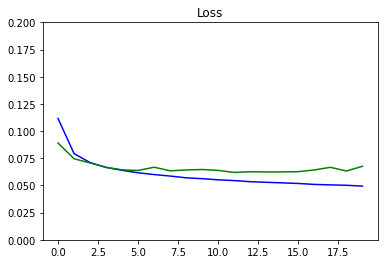

In [37]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [38]:
# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)


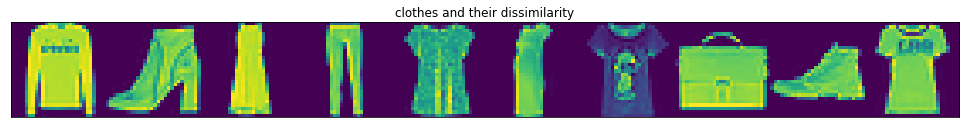

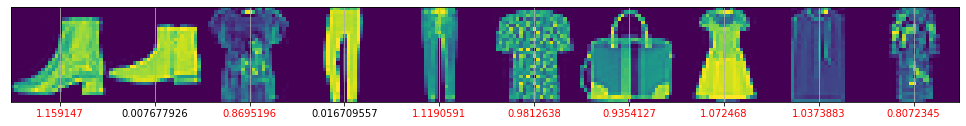

In [39]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)